In [1]:
import pyNUISANCE as pn

Welcome to JupyROOT 6.30/04


In [5]:
rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata",
    "recordpath":"/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/nue_CCPiplus_2024/submission-999999/submission.yaml"})
ana = hepdata_rec.analysis("cross_section")

In [3]:
probe_flux_count = ana.get_probe_flux(False)
probe_flux_count_density = ana.get_probe_flux(True)

pn.convert.ROOT.write_TH1("flux_for_t2k_nuepi.root",
                          "flux_count", probe_flux_count.spectrum,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_t2k_nuepi.root",
                          "flux_count_density", probe_flux_count_density.spectrum,False,"UPDATE")

print(probe_flux_count.probe_pdg)
print(probe_flux_count.source)
[ str(tgt) for tgt in ana.get_target() ]

12
/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/nue_CCPiplus_2024/submission-999999/best_fit_nue_flux.yaml


['1000060120[12]', '1000010010']

In [4]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_t2k_nuepi.hepmc3.gz ]; then
    neut-quickstart -t CH -s nue \
                -f flux_for_t2k_nuepi.root,flux_count \
                -n 100000 \
                -o events_for_t2k_nuepi.hepmc3.gz
fi

In [5]:
neut_events = pn.EventSource("events_for_t2k_nuepi.hepmc3.gz")
if not neut_events:
    print("Failed to read file")

In [6]:
import ROOT
import numpy as np

dr = ROOT.TFile("/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/nue_CCPiplus_2024/release/xsec_data_3D.root")

def get_hist_vals(name):
    dh = dr.Get(name)
    return np.array([float(f"{dh.GetBinContent(i+1):.3e}") for i in range(dh.GetXaxis().GetNbins())])

all_hist = get_hist_vals("sel_best_fit")[3:]
all_p_e = get_hist_vals("sel_best_fit_elecmom")
all_cos_theta_e = get_hist_vals("sel_best_fit_eleccos")
all_p_pi = get_hist_vals("sel_best_fit_pimom")

p_e_widths = np.array([ (1.7 - 0.35), (30 - 1.7), (1.7 - 0.35), (30 - 1.7), (1.7 - 0.35), (30 - 1.7), (1.7 - 0.35), (30 - 1.7) ])
cos_theta_e_widths = np.array([ (0.94 - 0.7), (0.94 - 0.7), (1 - 0.94), (1 - 0.94), (0.94 - 0.7), (0.94 - 0.7), (1 - 0.94), (1 - 0.94) ])
p_pi_widths = np.array([ (0.45 - 0), (0.45 - 0), (0.45 - 0), (0.45 - 0), (1.5 - 0.45), (1.5 - 0.45), (1.5 - 0.45), (1.5 - 0.45) ]) * 1E3

print(f"all_hist = {all_hist}")

constructed_p_e = [ 0,0 ]
for i in [4,6,8,10]:
    constructed_p_e[0] += all_hist[i-4] * cos_theta_e_widths[i-4] * p_pi_widths[i-4]
for i in [5,7,9,11]:
    constructed_p_e[1] += all_hist[i-4] * cos_theta_e_widths[i-4] * p_pi_widths[i-4]

print(f"\nconstructed_p_e = {constructed_p_e}")
print(f"official_p_e = {all_p_e}")

constructed_cos_theta_e = [ 0,0 ]
for i in [4,5,8,9]:
    constructed_cos_theta_e[0] += all_hist[i-4] * p_e_widths[i-4] * p_pi_widths[i-4]
for i in [6,7,10,11]:
    constructed_cos_theta_e[1] += all_hist[i-4] * p_e_widths[i-4] * p_pi_widths[i-4]

print(f"\nconstructed_cos_theta_e = {constructed_cos_theta_e}")
print(f"all_cos_theta_e = {all_cos_theta_e}")

constructed_p_pi = [ 0,0 ]
for i in [4,5,6,7]:
    constructed_p_pi[0] += all_hist[i-4] * p_e_widths[i-4] * cos_theta_e_widths[i-4]
for i in [8,9,10,11]:
    constructed_p_pi[1] += all_hist[i-4] * p_e_widths[i-4] * cos_theta_e_widths[i-4]

print(f"\nconstructed_p_pi = {constructed_p_pi}")
print(f"all_p_pi = {all_p_pi}")

all_hist = [ 1.181e-38  1.597e-40  2.085e-38  1.917e-39  5.054e-40  2.915e-42
 -1.278e-39  2.911e-40]

constructed_p_e = [1.8852768000000004e-36, 8.808048000000006e-38]
official_p_e = [1.885e-39 8.809e-41]

constructed_cos_theta_e = [1.0011378225e-35, 4.39178415e-35]
all_cos_theta_e = [1.001e-38 4.392e-38]

constructed_p_pi = [9.855038400000004e-39, 5.7431808000000036e-40]
all_p_pi = [9.856e-39 5.743e-40]


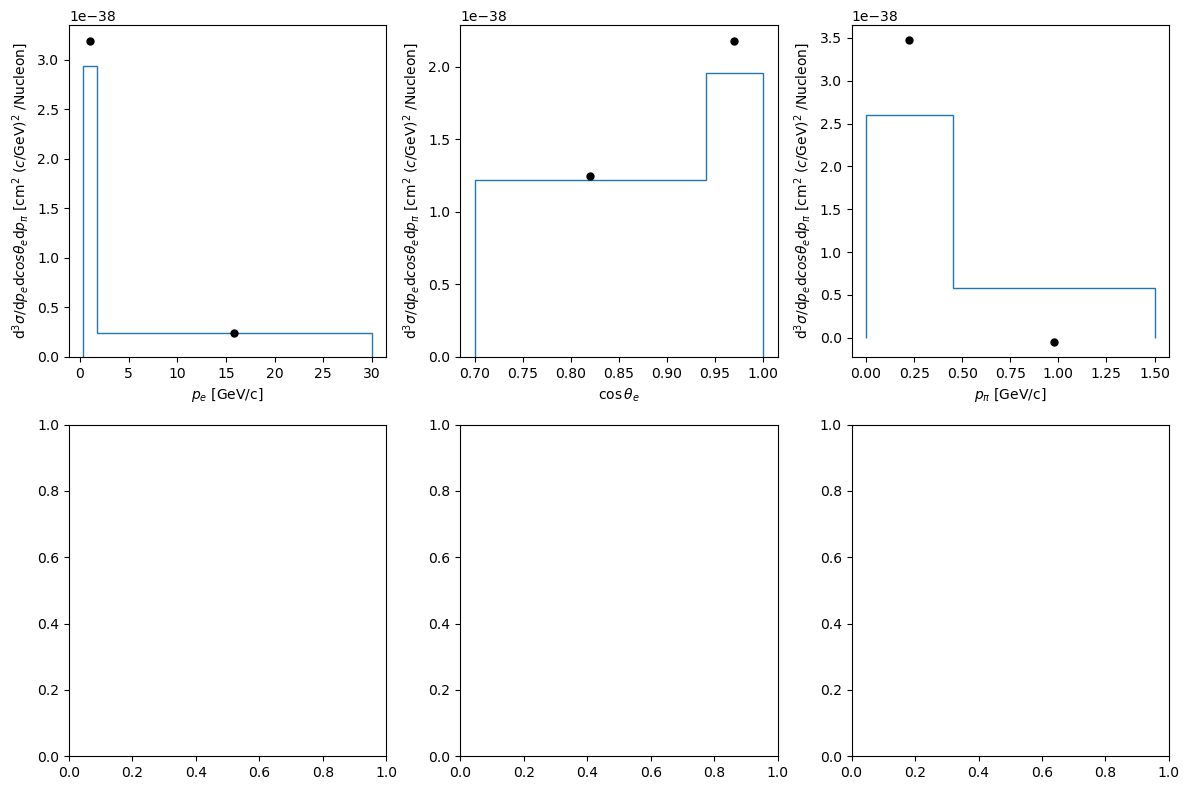

In [7]:
import matplotlib.pyplot as plt

comparison = ana.process(neut_events)

pred = comparison.predictions[0]

fig, axes = plt.subplots(2,3, figsize=(12,8))

for i in range(3):
    d_proj = comparison.data[0].project(i)

    d_proj.mpl().data_hist(plot_axis=axes[0][i])

    p_proj = pred.project(i)
    p_proj.values = p_proj.values * 2
    
    p_proj.mpl().hist(histtype="step", plot_axis=axes[0][i])

fig.tight_layout()
fig.show()